In [2]:
import pandas as pd
import pandas.rpy.common as com
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import brewer2mpl
from IPython.display import FileLink
import seaborn as sns
%matplotlib inline

/opt/anaconda/lib/python2.7/site-packages/pandas/rpy/__init__.py:8: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2, found here: http://rpy.sourceforge.net
  "like rpy2, found here: http://rpy.sourceforge.net", FutureWarning)


In [3]:
df_all = pd.read_csv("../data/l2fc_table.csv")

In [6]:
df_pivot = df_all.pivot_table(index="OTU", columns=["Treatment","Day"], values="log2FoldChange")

OTU_series = df_all.groupby("OTU").first()["Rank2"]
df_pivot = df_pivot.join(OTU_series)

phyla = df_all.sort("log2FoldChange").groupby("Rank2").last()
phyla.sort("log2FoldChange", ascending=False, inplace=True)

xd = dict([(p, x + 1) for x, p in enumerate(phyla.index.tolist())])
xmax = np.max(xd.values()) + 1
X = []
for p in df_pivot.Rank2:
    try:
        X.append(xd[p])
    except KeyError:
        X.append(xmax)
df_pivot["X"] = X

m1 = brewer2mpl.get_map("Paired", "qualitative", 9)
m2 = brewer2mpl.get_map("Dark2", "qualitative", 8)
colors = m1.hex_colors + m2.hex_colors
cd = dict(zip(phyla.index.tolist(), colors))
phylum_color = []
for p in df_pivot.Rank2:
    try:
        phylum_color.append(cd[p])
    except KeyError:
        phylum_color.append("#151515")
df_pivot["phylum_color"] = phylum_color

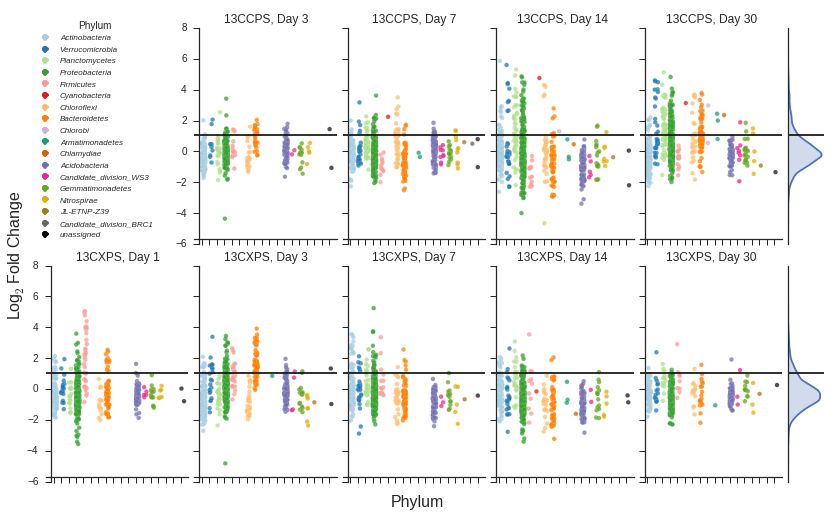

In [7]:
df = df_pivot

thresh = df_all["log2FoldChange"].iloc[0]

fig = plt.figure()
fig.set_size_inches(12,7)

gs = gridspec.GridSpec(nrows = 2, ncols = 6, width_ratios=[1,1,1,1,1,0.25], 
                       left=0.05, right=0.95, bottom=0.05, top=0.95,
                       hspace=0.1, wspace=0.05)


N = len(phyla.index) + 1
treatment = ["13CCPS", "13CXPS"]
days = [1,3,7,14,30]
ncol = 5
nrow = 2
for j, d in zip(range(ncol), days):
    for i, t in zip(range(nrow), treatment):
        try:
            with sns.axes_style("ticks"):
                ax = fig.add_subplot(gs[i,j])            
                points = ax.scatter(df.X + 0.45 * np.random.random(len(df.X)),
                                df[(t,d)], 
                                alpha = 0.75, 
                                c = df.phylum_color.tolist(), 
                                s = 20, 
                                linewidth=0.10, 
                                edgecolor = "#ffffff")
                ax.axhline(thresh, color = "#151515")
                ax.set_title("%s, Day %s"%(t, d))
                sns.despine(ax=ax, offset=-5)
        except KeyError:
            ax.set_visible(False)
            continue

axs = fig.get_axes()
xmin = np.array([axi.get_xlim()[0] for axi in axs]).min()
xmax = np.array([axi.get_xlim()[1] for axi in axs]).max()            

for axi in axs:
    axi.set_xlim([xmin,xmax])

with sns.axes_style("white"):
    axHistX = fig.add_subplot(gs[0, 5])

    sns.kdeplot(df_all[df_all["Treatment"]=="13CCPS"]["log2FoldChange"].values, 
                ax=axHistX, 
                vertical = True, 
                shade = True)
    sns.despine(ax = axHistX, trim = False,  bottom = True)
        
    axHistX.axhline(thresh, color = "#151515")

    axHistY = fig.add_subplot(gs[1, 5])
    
    sns.kdeplot(df_all[df_all["Treatment"]=="13CXPS"]["log2FoldChange"].values, 
                ax=axHistY, 
                vertical = True, 
                shade = True)
    
    sns.despine(ax = axHistY, trim = False, bottom = True)

    axHistY.axhline(thresh, color = "#151515")

axs = fig.get_axes()
xmin = np.array([axi.get_xlim()[0] for axi in axs]).min()
xmax = np.array([axi.get_xlim()[1] for axi in axs]).max()
ymin = np.array([axi.get_ylim()[0] for axi in axs]).min()
ymax = np.array([axi.get_ylim()[1] for axi in axs]).max()

for i, axi in enumerate(axs):
    if i == 10:
        axi.set_xticklabels([])
        axi.set_ylim([ymin,ymax])
        continue
    elif i == 11:
        axi.set_xticklabels([])
        axi.set_ylim([ymin,ymax])
        #axi.set_xticklabels([])
        #xi.set_xlabel("kernel density")
        continue
    axi.set_ylim([ymin,ymax])
    #axi.set_xticks(range(len(phyla.index.tolist()) + 1))\
    axi.set_xticks(np.arange(N) + 1)
    axi.set_xticklabels([])
    axi.set_xlim([0, N+1])
    
for axi in axs[3:]:
    axi.set_yticklabels([])

#axs[-1].set_xticklabels(axs[-1].get_xticks(), rotation = -90, size = 8)
axs[-1].set_xlim(axs[-2].get_xlim())

fig.text(0.005, 0.5, r"Log$_{2}$ Fold Change", rotation="vertical", va ="center", fontsize=16)
fig.text(0.45, 0, "Phylum", fontsize=16)

dummy_lines = []
for p in phyla.index.tolist():
    l, = axs[0].plot([1],[1], "o", color = cd[p], label = p)
    dummy_lines.append(l)

l, = axs[0].plot([1],[1], "o", color = "k", label = "unassigned")
dummy_lines.append(l)

leg = fig.legend(dummy_lines, phyla.index.tolist() + ["unassigned"], "upper left", ncol=1, numpoints=1, 
           bbox_to_anchor=(0.035, 1.00), frameon = False, prop = {"size":8, "style":"italic"})

leg.set_title("Phylum")

In [8]:
fig.savefig("figs/l2fc_fig.pdf", bbox_inches = "tight")
FileLink("figs/l2fc_fig.pdf")

/home/chuck/working/CSIP_succession_data_analysis/figures_and_stats/figs/l2fc_fig.pdf

In [9]:
fig.savefig("figs/l2fc_fig.png", bbox_inches = "tight", dpi = 500)
FileLink("figs/l2fc_fig.png")

/home/chuck/working/CSIP_succession_data_analysis/figures_and_stats/figs/l2fc_fig.png

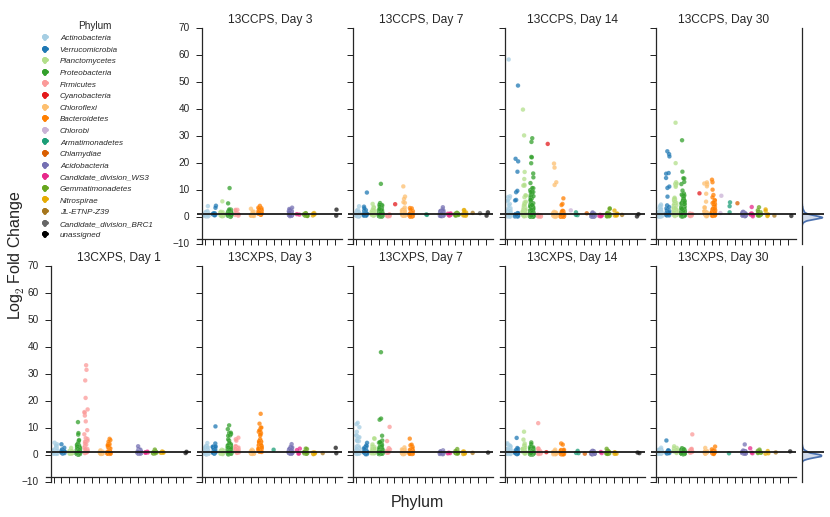

In [12]:
df = df_pivot

thresh = df_all["log2FoldChange"].iloc[0]

fig = plt.figure()
fig.set_size_inches(12,7)

gs = gridspec.GridSpec(nrows = 2, ncols = 6, width_ratios=[1,1,1,1,1,0.15], 
                       left=0.05, right=0.95, bottom=0.05, top=0.95,
                       hspace=0.1, wspace=0.05)


N = len(phyla.index) + 1
treatment = ["13CCPS", "13CXPS"]
days = [1,3,7,14,30]
ncol = 5
nrow = 2
for j, d in zip(range(ncol), days):
    for i, t in zip(range(nrow), treatment):
        try:
            with sns.axes_style("ticks"):
                ax = fig.add_subplot(gs[i,j])            
                points = ax.scatter(df.X + 0.45 * np.random.random(len(df.X)),
                                2 ** df[(t,d)], 
                                alpha = 0.75, 
                                c = df.phylum_color.tolist(), 
                                s = 20, 
                                linewidth=0.10, 
                                edgecolor = "#ffffff")
                ax.axhline(thresh, color = "#151515")
                ax.set_title("%s, Day %s"%(t, d))
                sns.despine(ax=ax, offset=-5)
        except KeyError:
            ax.set_visible(False)
            continue

axs = fig.get_axes()
xmin = np.array([axi.get_xlim()[0] for axi in axs]).min()
xmax = np.array([axi.get_xlim()[1] for axi in axs]).max()            

for axi in axs:
    axi.set_xlim([xmin,xmax])

with sns.axes_style("white"):
    axHistX = fig.add_subplot(gs[0, 5])

    sns.kdeplot(df_all[df_all["Treatment"]=="13CCPS"]["log2FoldChange"].values, 
                ax=axHistX, 
                vertical = True, 
                shade = True)
    sns.despine(ax = axHistX, trim = False,  bottom = True)
        
    axHistX.axhline(thresh, color = "#151515")

    axHistY = fig.add_subplot(gs[1, 5])
    
    sns.kdeplot(df_all[df_all["Treatment"]=="13CXPS"]["log2FoldChange"].values, 
                ax=axHistY, 
                vertical = True, 
                shade = True)
    
    sns.despine(ax = axHistY, trim = False, bottom = True)

    axHistY.axhline(thresh, color = "#151515")

axs = fig.get_axes()
xmin = np.array([axi.get_xlim()[0] for axi in axs]).min()
xmax = np.array([axi.get_xlim()[1] for axi in axs]).max()
ymin = np.array([axi.get_ylim()[0] for axi in axs]).min()
ymax = np.array([axi.get_ylim()[1] for axi in axs]).max()

for i, axi in enumerate(axs):
    if i == 10:
        axi.set_xticklabels([])
        axi.set_ylim([ymin,ymax])
        continue
    elif i == 11:
        axi.set_xticklabels([])
        axi.set_ylim([ymin,ymax])
        #axi.set_xticklabels([])
        #xi.set_xlabel("kernel density")
        continue
    axi.set_ylim([ymin,ymax])
    #axi.set_xticks(range(len(phyla.index.tolist()) + 1))\
    axi.set_xticks(np.arange(N) + 1)
    axi.set_xticklabels([])
    axi.set_xlim([0, N+1])
    
for axi in axs[3:]:
    axi.set_yticklabels([])

#axs[-1].set_xticklabels(axs[-1].get_xticks(), rotation = -90, size = 8)
axs[-1].set_xlim(axs[-2].get_xlim())

fig.text(0.005, 0.5, r"Log$_{2}$ Fold Change", rotation="vertical", va ="center", fontsize=16)
fig.text(0.45, 0, "Phylum", fontsize=16)

dummy_lines = []
for p in phyla.index.tolist():
    l, = axs[0].plot([1],[1], "o", color = cd[p], label = p)
    dummy_lines.append(l)

l, = axs[0].plot([1],[1], "o", color = "k", label = "unassigned")
dummy_lines.append(l)

leg = fig.legend(dummy_lines, phyla.index.tolist() + ["unassigned"], "upper left", ncol=1, numpoints=1, 
           bbox_to_anchor=(0.035, 1.00), frameon = False, prop = {"size":8, "style":"italic"})

leg.set_title("Phylum")